In [1]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt

from chromatix.experimental.modified_born_series.sample import (
    EmptySample,
    Source,
    add_absorbing_bc,
)
from chromatix.experimental.modified_born_series.solver import solve

%config InlineBackend.figure_format='retina'

In [2]:
wavelength = 0.5  # [mum]
material_refractive_index = 1.5
n_background = 1.0
k0 = 2 * jnp.pi / wavelength
grid_shape = [256, 256 * 4 // 3, 1]  # 2D; just set the last dimension to 1
spacing = wavelength / 8

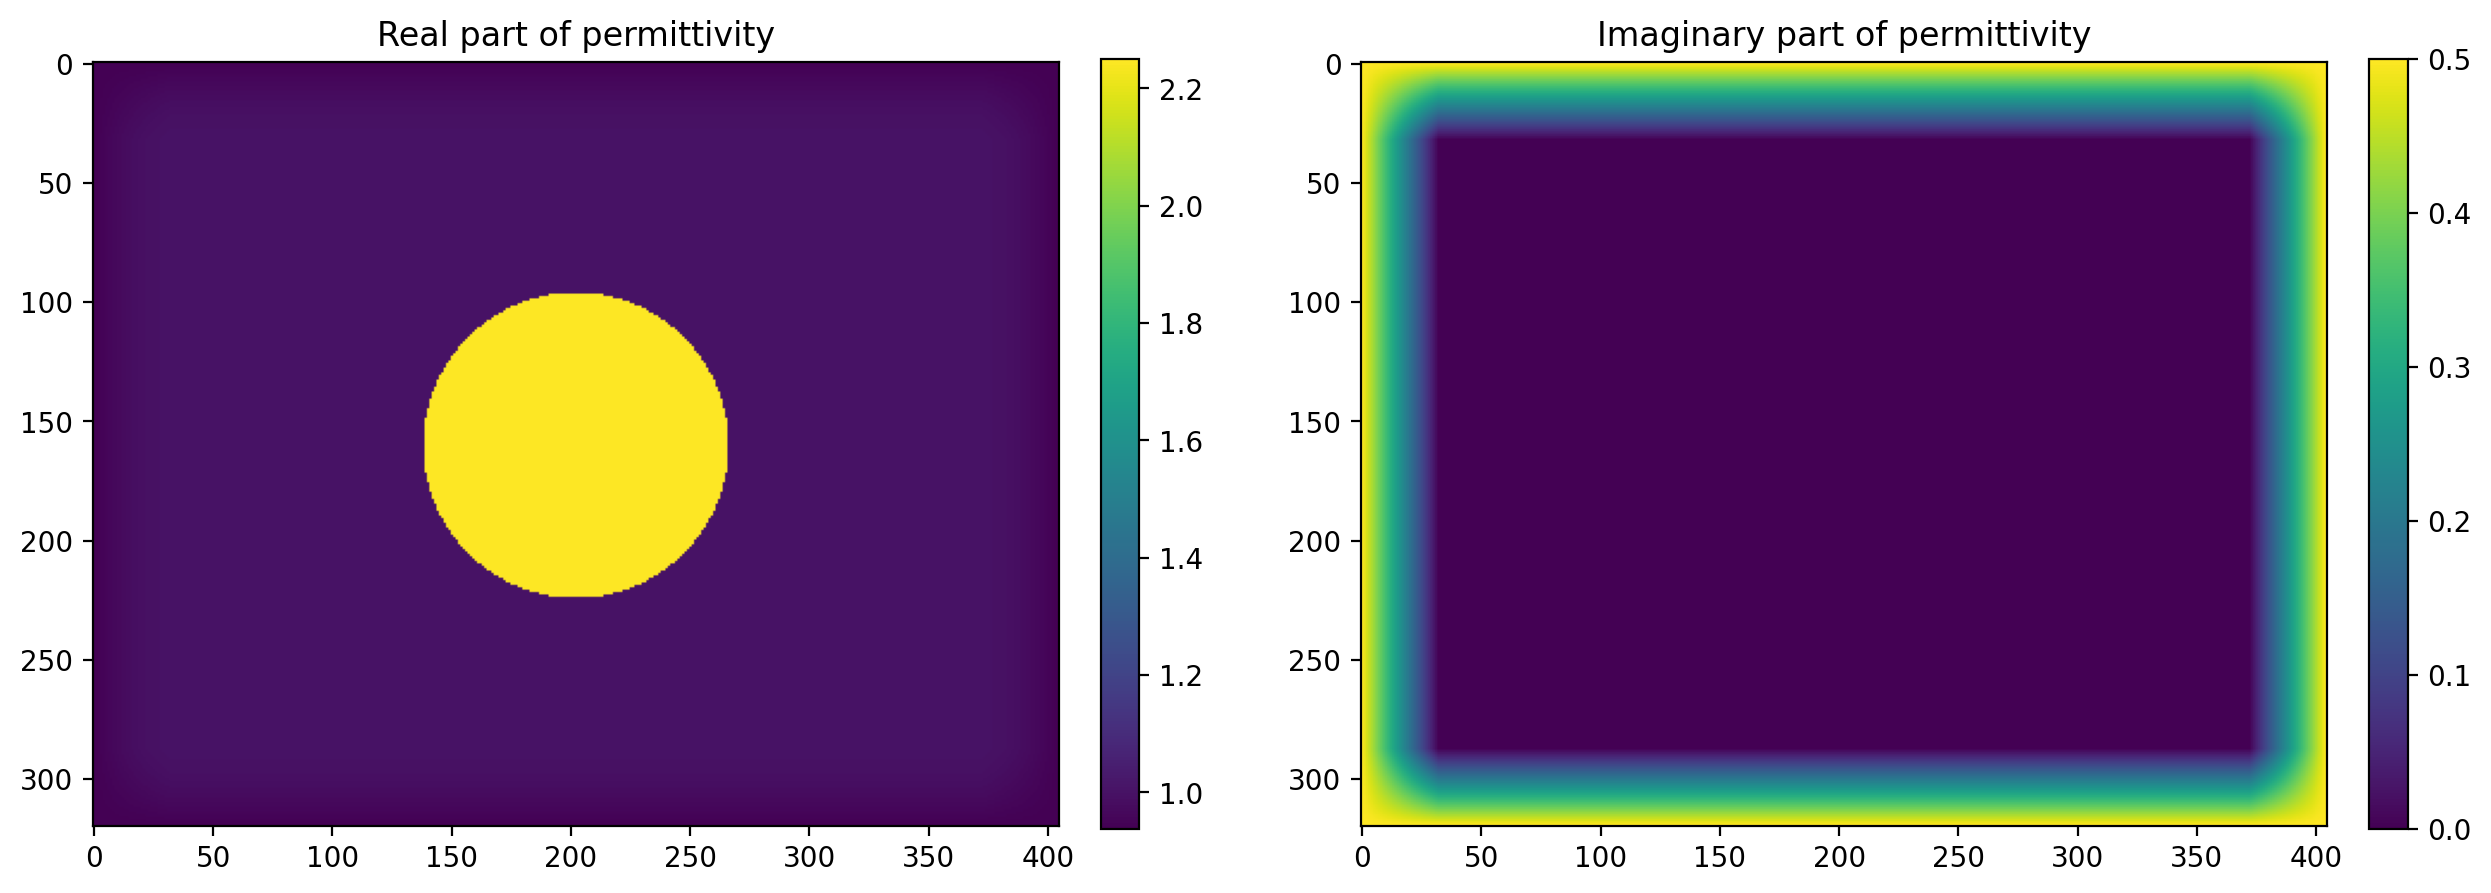

In [3]:
# Definining sample
sample = EmptySample(grid_shape, spacing)

dn = material_refractive_index - n_background
object_radius = (sample.extent[0] / 2) / 2
object = jnp.sum(sample.grid**2, axis=-1) < object_radius**2
refractive_index = 1.0 + dn * object
sample = sample.replace(permittivity=refractive_index**2)

# Add absorbing boundaries
sample = add_absorbing_bc(sample, axis=(0, 1), thickness=2.0, max_extinction=0.25)


plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[:, :, 0].real)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[:, :, 0].imag)
plt.colorbar(fraction=0.046, pad=0.04)

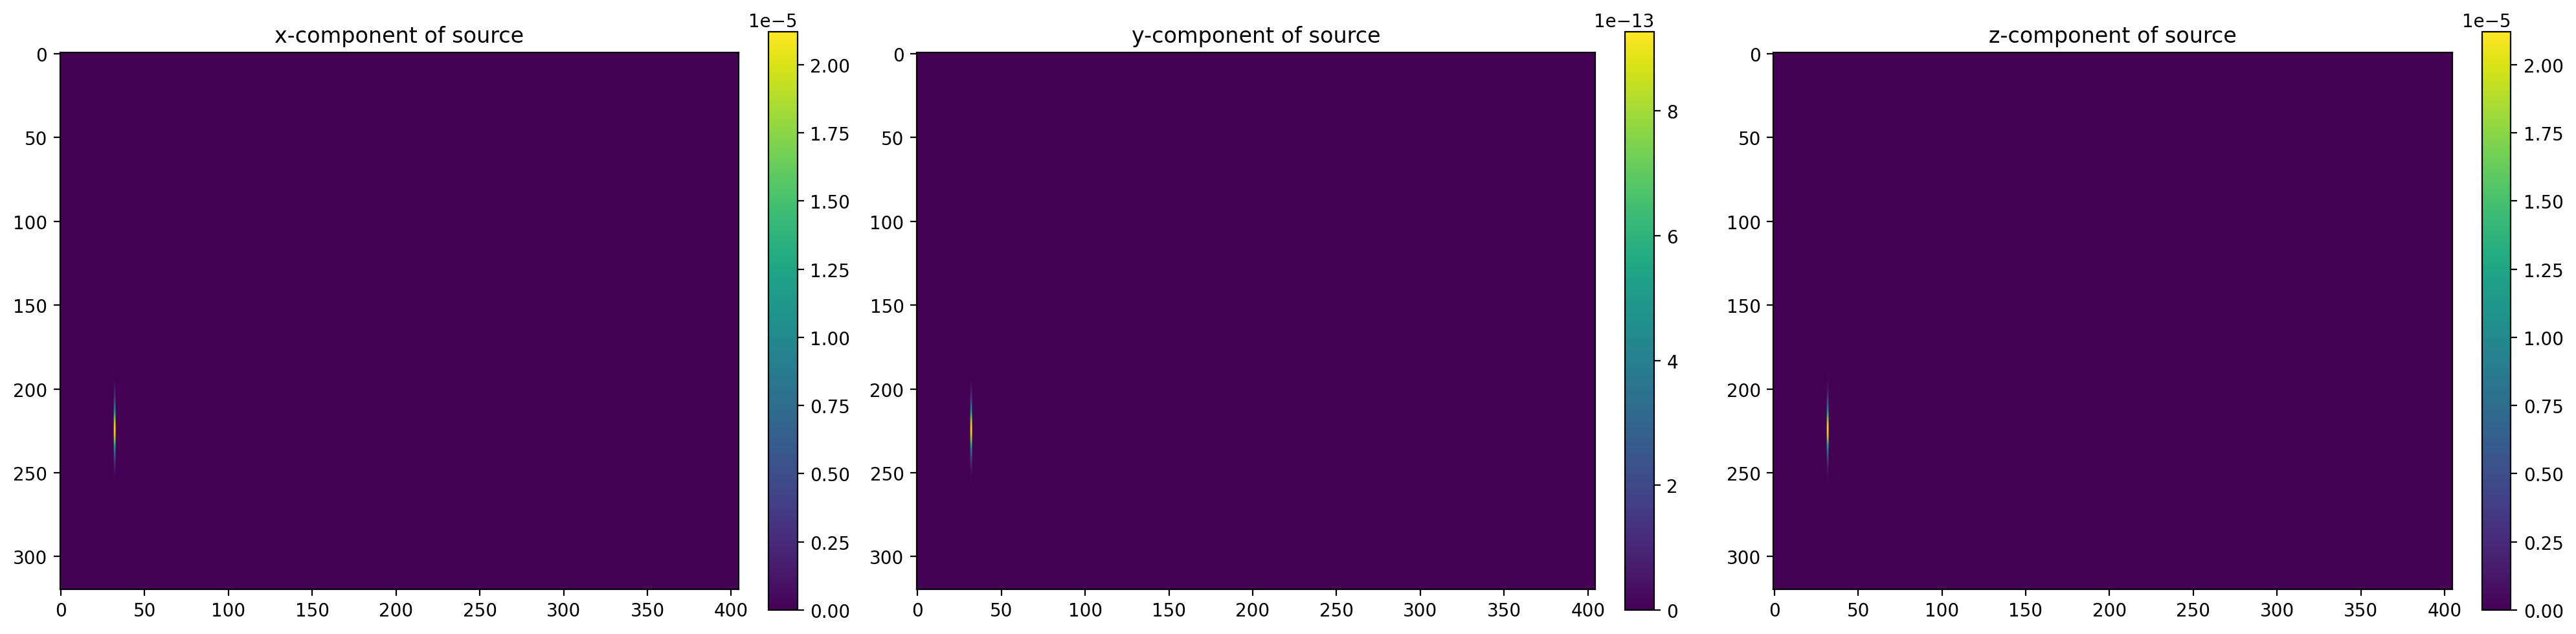

In [4]:
# Making the source
incident_angle = 1 / 2 * jnp.pi


def rot_Z(a):
    return jnp.array(
        [[jnp.cos(a), -jnp.sin(a), 0], [jnp.sin(a), jnp.cos(a), 0], [0, 0, 1]]
    )


incident_k = rot_Z(incident_angle) * k0 @ jnp.array([1, 0, 0])
source_polarization = rot_Z(incident_angle) @ jnp.array([0, 1, 1j]) / jnp.sqrt(2)

# Current density
beam_radius = (sample.extent[0] / 16) / 2
source_pixel_index = int(2.0 / sample.spacing)
grid = sample.grid[:, source_pixel_index]

current_density = jnp.exp(1j * jnp.sum(grid * incident_k, axis=-1))  # x z
current_density = current_density * jnp.exp(
    -0.5 * ((grid[..., 0] - object_radius) / beam_radius) ** 2
)
current_density = source_polarization * current_density[..., None]
current_density = (
    jnp.zeros((*sample.shape, 3), dtype=jnp.complex64)
    .at[:, source_pixel_index]
    .set(current_density)
)
source = Source(current_density, k0)


plt.figure(figsize=(20, 5), layout="tight")
plt.subplot(131)
plt.title("x-component of source")
plt.imshow(jnp.abs(source.field[:, :, 0, 0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("y-component of source")
plt.imshow(jnp.abs(source.field[:, :, 0, 1]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("z-component of source")
plt.imshow(jnp.abs(source.field[:, :, 0, 2]))
plt.colorbar(fraction=0.046, pad=0.04)

In [5]:
# Actually solving
E = eqx.filter_jit(solve)(sample, source)
E = E[sample.ROI]  # extract ROI, we don't care about boundaries

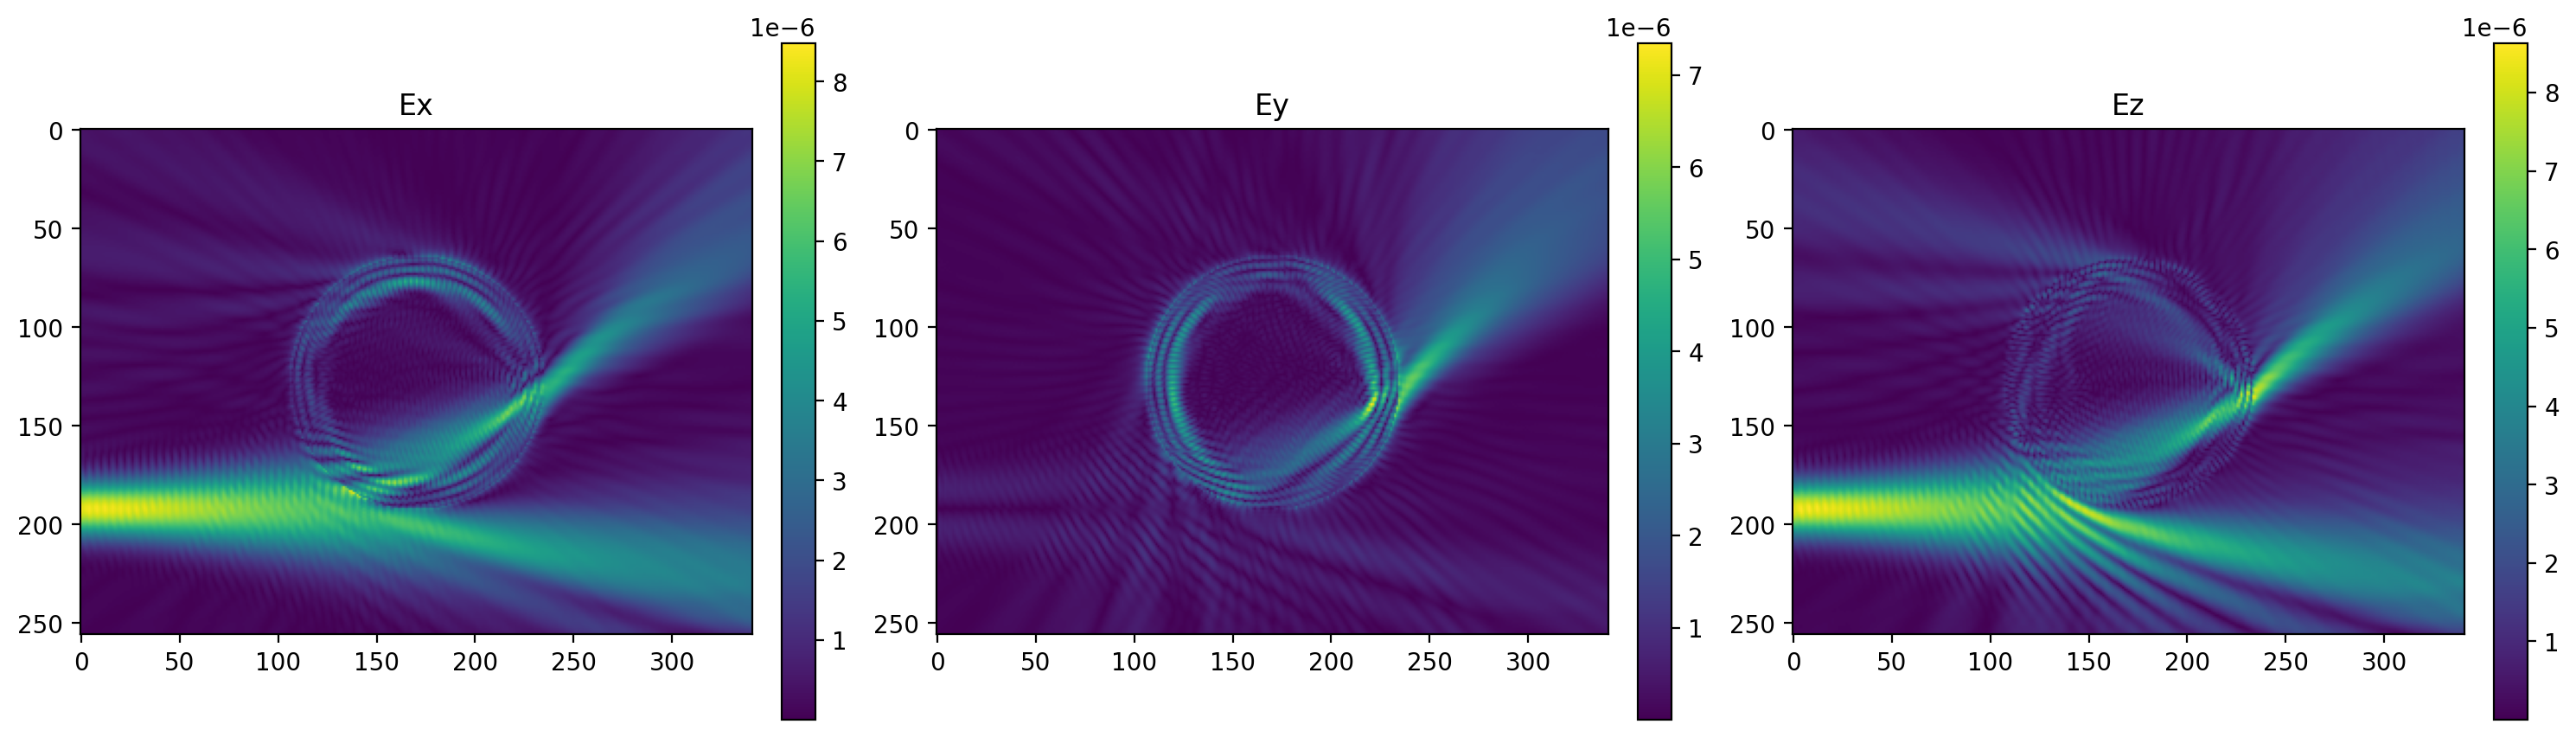

In [6]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.abs(E)[:, :, 0, 0])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.abs(E)[:, :, 0, 1])
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.abs(E)[:, :, 0, 2])
plt.colorbar(fraction=0.046, pad=0.04)